In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("OnlineRetail.csv", parse_dates=["InvoiceDate"], encoding="ISO-8859-1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Drop rows with no customer ID
df = df.dropna(subset=["CustomerID"])

# Remove cancellations (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep only positive Quantity and UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Add a TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
# Snapshot date = day after last purchase
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# RFM table
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,   # Recency
    "InvoiceNo": "nunique",                                    # Frequency
    "TotalPrice": "sum"                                        # Monetary
}).rename(columns={"InvoiceDate": "Recency",
                   "InvoiceNo": "Frequency",
                   "TotalPrice": "Monetary"})

rfm = rfm.reset_index()
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


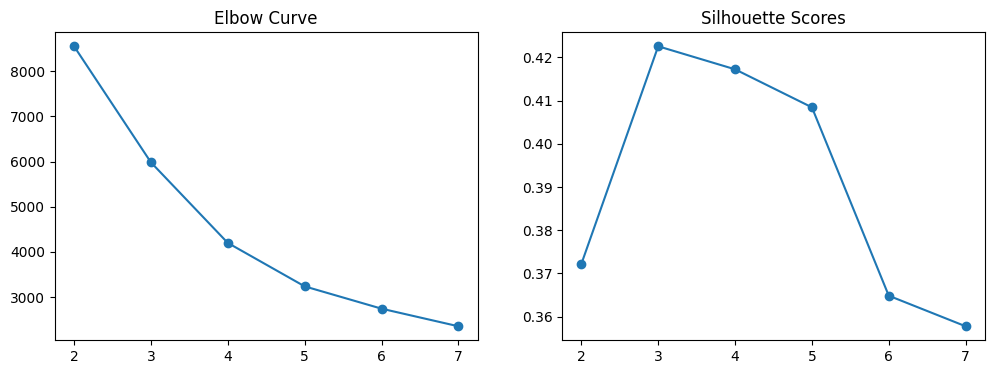

,Recency,Frequency,Monetary
Cluster,,,
0,52.952404,2.196212,586.880754
1,253.365538,1.456175,408.620370
2,30.237829,8.654429,4471.947055
3,5.772727,77.454545,76791.632727


In [5]:
from sklearn.decomposition import PCA

X = rfm[["Recency", "Frequency", "Monetary"]].copy()
X["Monetary_log"] = np.log1p(X["Monetary"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["Recency", "Frequency", "Monetary_log"]])

# Try different cluster sizes
inertias = []
sil_scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(2,8), inertias, "-o")
plt.title("Elbow Curve")
plt.subplot(1,2,2)
plt.plot(range(2,8), sil_scores, "-o")
plt.title("Silhouette Scores")
plt.show()

# Pick k=4 (example) and assign clusters
km = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = km.fit_predict(X_scaled)

rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()


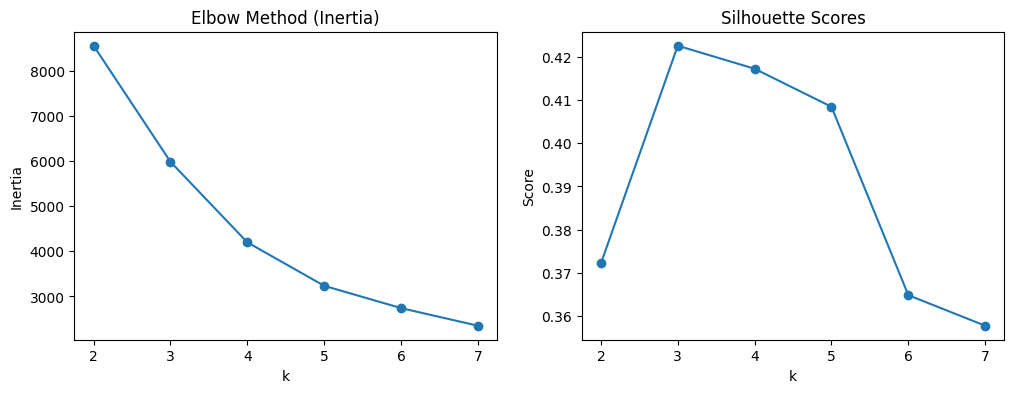

In [6]:
# Elbow and Silhouette plots
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, "-o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, "-o")
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")

plt.show()


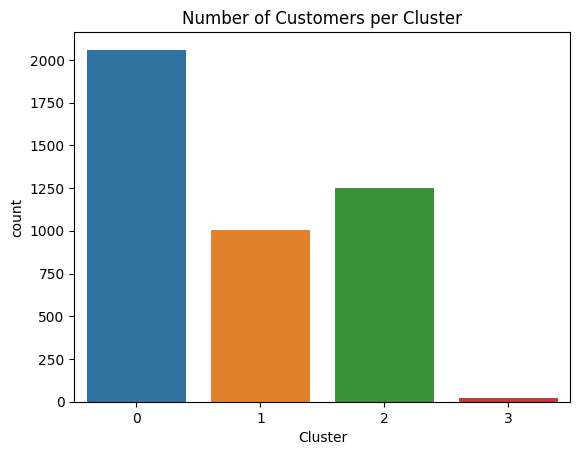

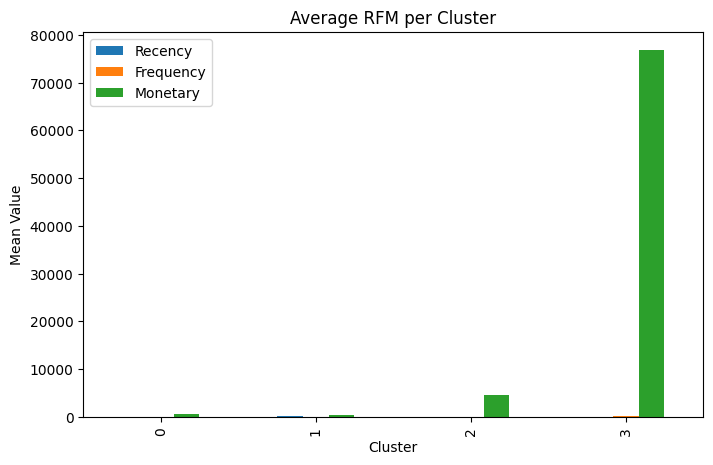

In [7]:
# Number of customers in each cluster
sns.countplot(x="Cluster", data=rfm, palette="tab10")
plt.title("Number of Customers per Cluster")
plt.show()

# Average RFM values per cluster
rfm.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean().plot(kind="bar", figsize=(8,5))
plt.title("Average RFM per Cluster")
plt.ylabel("Mean Value")
plt.show()


In [8]:
y = rfm["Monetary"]
X = rfm[["Recency", "Frequency", "Cluster"]]
X = pd.get_dummies(X, columns=["Cluster"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2: -0.09987797937563303
RMSE: 10614.829953930566


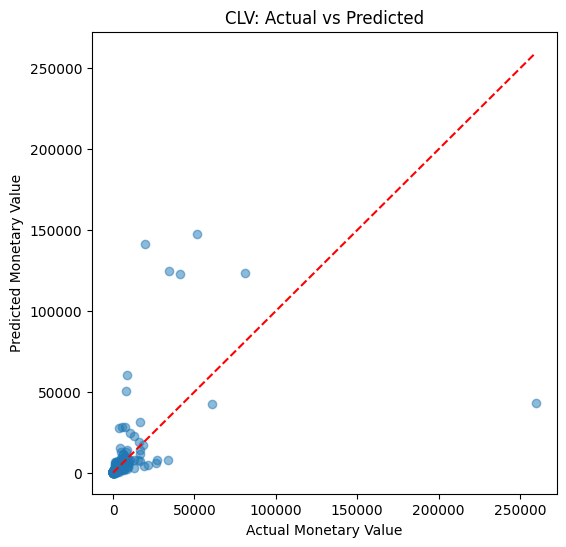

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual Monetary Value")
plt.ylabel("Predicted Monetary Value")
plt.title("CLV: Actual vs Predicted")
plt.show()


In [10]:
# Define churn as Recency > 90 days
rfm["Churn"] = (rfm["Recency"] > 90).astype(int)

y = rfm["Churn"]
X = rfm[["Recency", "Frequency", "Monetary", "Cluster"]]
X = pd.get_dummies(X, columns=["Cluster"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = LogisticRegression(max_iter=200, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00       290

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

Confusion Matrix:
 [[578   0]
 [  0 290]]
ROC AUC: 1.0


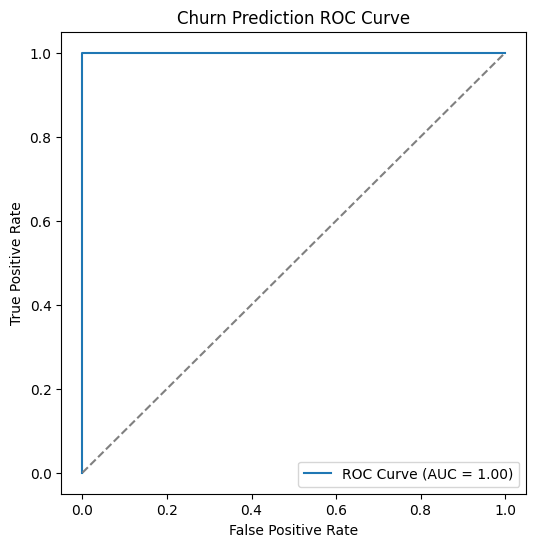

In [11]:
from sklearn.metrics import roc_curve

y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1], [0,1], 'k--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Churn Prediction ROC Curve")
plt.legend()
plt.show()
